# NLP on IMDB Dataset

Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

In [2]:
import numpy as np
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation,Dropout,Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D,LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Importing the Dataset

In [51]:
movie_reviews=pd.read_csv('IMDB Dataset.csv')

movie_reviews.isnull().values.any
movie_reviews.shape

(50000, 2)

In [4]:
movie_reviews['sentiment'][1]

'positive'

Checking the distribution of values in the dataset

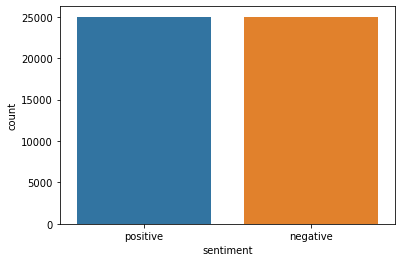

In [10]:
import seaborn as sns

sns.countplot(x='sentiment',data=movie_reviews)

Removing the unnecessary HTML tags from the Data

In [11]:
def preprocess_text(sen):
    sentence=remove_tags(sen)
    sentence=re.sub('[^a-zA-Z]',' ',sentence)
    sentence=re.sub(r"\s+[a-zA-Z]\s+",' ',sentence)
    sentence=re.sub(r'\s+',' ',sentence)
    return sentence

In [12]:
TAG_RE=re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('',text)

In [13]:
X=[]
sentences=list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

Making the rows with Positive as 1 and rows as 0 for negative reviews

In [14]:
y=movie_reviews['sentiment']

y=np.array(list(map(lambda x:1 if x=='positive' else 0,y)))

Splitting the Train and Test set

In [52]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25, random_state=42)

Tokenizing the Data

In [53]:
tokenizer=Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train=tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)

In [54]:
vocab_size=len(tokenizer.word_index)+1

maxlen=100
X_train=pad_sequences(X_train,padding='post',maxlen=maxlen)
X_test=pad_sequences(X_test,padding='post',maxlen=maxlen)

Here we will be using a pre-trained embedding, GloVe.

In [55]:
embeddings_dictionary=dict()
glove_file=open('glove.6B.100D.txt',encoding='utf8')

for line in glove_file:
    records=line.split()
    word=records[0]
    vector_dimensions=np.asarray(records[1:],dtype='float32')
    embeddings_dictionary[word]=vector_dimensions
glove_file.close()

In [56]:
embedding_matrix=np.zeros((vocab_size,100))

for word,index in tokenizer.word_index.items():
    embedding_vector=embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index]=embedding_vector
    

Considering the Final output as 2 nodes 

In [57]:
from keras.utils import to_categorical
y_test=to_categorical(y_test,2)
y_train=to_categorical(y_train,2)

Declaring the model without LSTM

In [58]:
model=Sequential()
embedding_layer=Embedding(vocab_size,100,weights=[embedding_matrix],input_length=maxlen,trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          9024800   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 20002     
Total params: 9,044,802
Trainable params: 20,002
Non-trainable params: 9,024,800
_________________________________________________________________


In [59]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [60]:
history=model.fit(X_train,y_train,batch_size=128,epochs=6,verbose=1,validation_split=0.2)

Epoch 1/6
235/235 [==============================] - 2s 6ms/step - loss: 0.6398 - accuracy: 0.6612 - val_loss: 0.5444 - val_accuracy: 0.7228
Epoch 2/6
235/235 [==============================] - 1s 6ms/step - loss: 0.4989 - accuracy: 0.7595 - val_loss: 0.5519 - val_accuracy: 0.7303
Epoch 3/6
235/235 [==============================] - 1s 6ms/step - loss: 0.4620 - accuracy: 0.7840 - val_loss: 0.5476 - val_accuracy: 0.7383
Epoch 4/6
235/235 [==============================] - 1s 5ms/step - loss: 0.4322 - accuracy: 0.8022 - val_loss: 0.5558 - val_accuracy: 0.7355
Epoch 5/6
235/235 [==============================] - 1s 5ms/step - loss: 0.4220 - accuracy: 0.8075 - val_loss: 0.5729 - val_accuracy: 0.7337
Epoch 6/6
235/235 [==============================] - 1s 6ms/step - loss: 0.4049 - accuracy: 0.8167 - val_loss: 0.5874 - val_accuracy: 0.7296


In [61]:
accuracy=model.evaluate(X_test,y_test)
print(accuracy[1]*100)

391/391 [==============================] - 0s 1ms/step - loss: 0.5843 - accuracy: 0.7324
73.24000000953674


As we can notice from the previous few steps the model accuracy is higher for the training set by about 8% which generally means that the model is overfitting the training set

In [62]:
import matplotlib.pyplot as plt

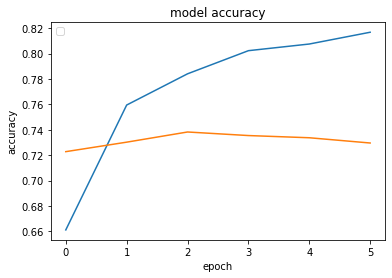

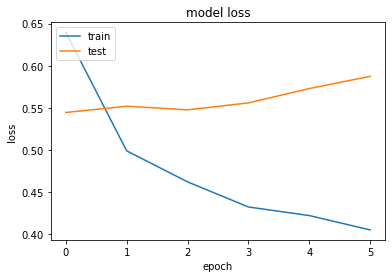

In [63]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [64]:
from keras.models import load_model

Saving the initial Model

In [65]:
model.save('simple.h5')

Creating a second model with LSTM

In [66]:
model=Sequential()
embedding_layer=Embedding(vocab_size,100,weights=[embedding_matrix],input_length=maxlen,trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(2,activation='softmax'))
model.compile(optimizer='adam',metrics=['accuracy'],loss='binary_crossentropy')
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          9024800   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 258       
Total params: 9,142,306
Trainable params: 117,506
Non-trainable params: 9,024,800
_________________________________________________________________


In [67]:
history=model.fit(X_train,y_train,batch_size=128,epochs=6,verbose=1,validation_split=0.2)

Epoch 1/6
235/235 [==============================] - 31s 130ms/step - loss: 0.5393 - accuracy: 0.7205 - val_loss: 0.5005 - val_accuracy: 0.7635
Epoch 2/6
235/235 [==============================] - 29s 122ms/step - loss: 0.4538 - accuracy: 0.7908 - val_loss: 0.4368 - val_accuracy: 0.7947
Epoch 3/6
235/235 [==============================] - 28s 121ms/step - loss: 0.4082 - accuracy: 0.8164 - val_loss: 0.4139 - val_accuracy: 0.8124
Epoch 4/6
235/235 [==============================] - 29s 121ms/step - loss: 0.3747 - accuracy: 0.8325 - val_loss: 0.4025 - val_accuracy: 0.8147
Epoch 5/6
235/235 [==============================] - 29s 122ms/step - loss: 0.3493 - accuracy: 0.8443 - val_loss: 0.3526 - val_accuracy: 0.8428
Epoch 6/6
235/235 [==============================] - 29s 123ms/step - loss: 0.3285 - accuracy: 0.8581 - val_loss: 0.3462 - val_accuracy: 0.8428


In [68]:
accuracy=model.evaluate(X_test,y_test)

391/391 [==============================] - 7s 17ms/step - loss: 0.3492 - accuracy: 0.8389


In [69]:
print(accuracy[1]*100)

83.88800024986267


As we can notice the training accuracy and the validation accuracy does not vary by a large amount 

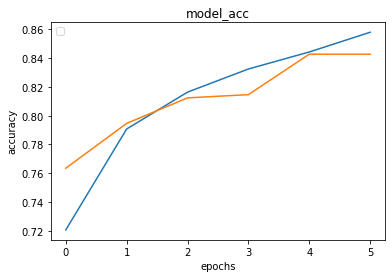

In [70]:
plt.title('model_acc')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','test'],loc='upper left')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

Saving the LSTM Model

In [73]:
model.save('LSTM_model1.h5')

Saving the Tokenizer as a pickle file

In [71]:
import pickle

In [72]:
with open('tokenizer.pickle','wb') as handle:
    pickle.dump(tokenizer,handle,protocol=pickle.HIGHEST_PROTOCOL)


In [74]:
with open('tokenizer.pickle','rb') as handle:
    tokenizer=pickle.load(handle)

# Testing The Model

In [100]:
test1=X[0]

In [101]:
y[0]

1

In [102]:
X[0]

'One of the other reviewers has mentioned that after watching just Oz episode you ll be hooked They are right as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to many Aryans Muslims gangstas Latinos Christians Italians Irish and more so scuffles death stares dodgy dealings and shady agreements are never far away would say the main appeal of the show is due to the fact that it goes where other shows wouldn dare Forget pretty picture

In [103]:
test1=tokenizer.texts_to_sequences(test1)
flat_list=[]
for sublist in test1:
    for item in sublist:
        flat_list.append(item)
flat_list=[flat_list]

test1=pad_sequences(flat_list,padding='post',maxlen=maxlen)
print(np.argmax(model.predict(test2)))

0
